In [1]:
using Pkg
Pkg.activate(".")
using SimilaritySearch, SimSearchManifoldLearning, LinearAlgebra, JLD2, CSV, DataFrames, TextSearch, Glob, StatsBase, Plots


  Activating project at `~/Research/RegionalSpanish/notebooks`
┌ Info: Precompiling SimilaritySearch [053f045d-5466-53fd-b400-a066f88fe02a]
└ @ Base loading.jl:1662
┌ Info: Precompiling UMAP [c4f8c510-2410-5be4-91d7-4fbaeb39457e]
└ @ Base loading.jl:1662
┌ Info: Precompiling JLD2 [033835bb-8acc-5ee8-8aae-3f567f8a3819]
└ @ Base loading.jl:1662
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1662
ERROR: LoadError: ccall method definition: argument 1 type doesn't correspond to a C type
Stacktrace:
 [1] top-level scope
   @ ~/.julia/packages/SentinelArrays/p1IoM/src/SentinelArrays.jl:209
 [2] include
   @ ./Base.jl:419 [inlined]
 [3] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt64}}, source::String)
   @ Base ./loading.jl:1554
 [4] top-level scope
   @ stdin:1
in expression starting at /home/sadit/.julia/packages/S

LoadError: Failed to precompile CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b] to /home/sadit/.julia/compiled/v1.8/CSV/jl_PEiwfg.

In [2]:
edir = "../data/SpanishLang/embeddings"
k = 33
common = CSV.read("../data/SpanishLang/common-tokens-per-region.tsv.gz", DataFrame, delim='\t')
subset!(common, :n_regions => n -> n .> 10)
cclist = split(first(subset(common, :n_regions => n -> n .== 26).country_codes), ',')
@info sort!(cclist)

┌ Info: SubString{String}["ALL", "AR", "BO", "BR", "CA", "CL", "CO", "CR", "CU", "DO", "EC", "ES", "FR", "GB", "GQ", "GT", "HN", "MX", "NI", "PA", "PE", "PR", "PY", "SV", "US", "UY", "VE"]
└ @ Main In[2]:6


In [3]:
#=
function encode_model_(vocab, umapmodel)
   #  ivocab = Dict(token => i for (i, token) in enumerate(vocab))
    obj = Dict{Symbol,Dict{Symbol,Float64}}()
    
    for (i, (idcol, distcol)) in enumerate(zip(eachcol(umapmodel.knns), eachcol(umapmodel.dists)))
        v = Dict(vocab[idcol[i]] => distcol[i] for i in eachindex(idcol, distcol))
        normalize!(v)
        obj[vocab[i]] = v
    end

    obj
end

function SimilaritySearch.evaluate(D::SumDist, model0, model1)
    s = 0.0
    if length(model1) < length(model0)
        model0, model1 = model1, model0
    end

    for (t, m0) in model0
        m1 = get(model1, t, nothing)
        if m1 === nothing
            continue
        end

        s += dot(m0, m1)
    end

    1.0 - s / length(model1) # |model1| >= |model0|
end

struct SumDist <: SemiMetric
end

function SimilaritySearch.evaluate(D::SumDist, model0, model1)
    s = 0.0
    for t in D.tokens
        m0 = get(model0, t, nothing)
        if m0 === nothing
            s += D.missing_cost
            continue
        end

        m1 = get(model1, t, nothing)
        if m1 === nothing
            s += D.missing_cost
            continue
        end

        s += evaluate(NormalizedCosineDistance(), m0, m1)
    end

    s / (length(D.tokens) * D.missing_cost)
end

=#

function encode_model(vocab, umapmodel)
    #vocab = Symbol.(vocab)
    #  ivocab = Dict(token => i for (i, token) in enumerate(vocab))
    obj = Dict{UInt64,Float64}()
    for (i, (idcol, distcol)) in enumerate(zip(eachcol(umapmodel.knns), eachcol(umapmodel.dists)))
        for j in eachindex(idcol, distcol)
            s = hash((vocab[i], vocab[idcol[j]]))
            obj[s] = distcol[j]
        end
    end
 
    normalize!(obj)
    obj
end

encode_model (generic function with 1 method)

In [4]:
db = []

for modelname in sort(glob(joinpath(edir, "umap+index-common-tokens-*.k=$k.jld2")))
    model_, vocab_ = load(modelname, "U2", "vocab")
    push!(db, encode_model(vocab_, model_))
end


In [5]:
dist = NormalizedCosineDistance()
n = length(cclist)
A = Matrix{Float64}(undef, n, n)

for (i, cc) in enumerate(cclist)
    u = db[i]
    A[i, i] = 0.0
    @time for j in i+1:n
        v = db[j]
        A[j, i] = A[i, j] = evaluate(dist, u, v)        
    end
end

  2.399725 seconds (32.25 k allocations: 1.730 MiB, 1.45% compilation time)
  2.106823 seconds (51 allocations: 1.203 KiB)
  1.204510 seconds (49 allocations: 1.156 KiB)
  1.478776 seconds (47 allocations: 1.109 KiB)
  1.303696 seconds (45 allocations: 1.062 KiB)
  1.872885 seconds (43 allocations: 1.016 KiB)
  1.734142 seconds (41 allocations: 992 bytes)
  1.405266 seconds (39 allocations: 944 bytes)
  0.383071 seconds (37 allocations: 896 bytes)
  1.339409 seconds (35 allocations: 848 bytes)
  1.301191 seconds (33 allocations: 800 bytes)
  1.230477 seconds (31 allocations: 752 bytes)
  0.806978 seconds (29 allocations: 704 bytes)
  0.793417 seconds (27 allocations: 656 bytes)
  0.036993 seconds (25 allocations: 608 bytes)
  0.775939 seconds (23 allocations: 560 bytes)
  0.622400 seconds (21 allocations: 512 bytes)
  0.850169 seconds (19 allocations: 464 bytes)
  0.486872 seconds (17 allocations: 416 bytes)
  0.596076 seconds (15 allocations: 368 bytes)
  0.547836 seconds (13 allocati

In [61]:
min_dist = 0.1
n_neighbors = 3
neg_sample_rate = 10
local_connectivity = 1

struct PreComputed <: SemiMetric
    A::Matrix{Float64}
end

function SimilaritySearch.evaluate(p::PreComputed, i, j)
    p.A[i, j]
end

index = ExhaustiveSearch(db=VectorDatabase(collect(1:size(A, 1))), dist=PreComputed(A))
#index = ExhaustiveSearch(db=A, dist=L2Distance())
U2 = UMAP_(index, 2; n_neighbors, neg_sample_rate, local_connectivity)
U3 = UMAP_(U2, 3; neg_sample_rate)
nothing

(n, n_neighbors, n_components) = (27, 3, 2)
  0.030496 seconds (300 allocations: 4.688 KiB)
  0.031525 seconds (300 allocations: 4.688 KiB)


*** computing allknn graph
*** computing graph
*** init embedding
*** fit ab / embedding
*** opt embedding


In [62]:
X = U2.embedding
C = U3.embedding
#C .= C .+ 5

for i in (1, 2, 3)
    v = @view C[i, :]
    s = 4 * std(v)
    v .= v ./ s .+ 0.5
    
    for j in eachindex(v)
        v[j] = clamp(v[j],  0, 1)
    end
end

C = [RGB(c...) for c in eachcol(C)]

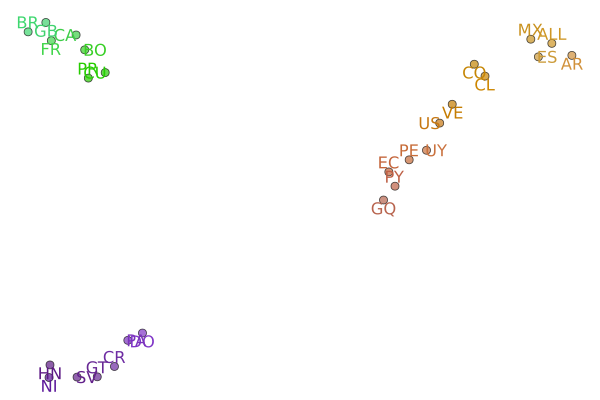

In [64]:

poslist = rand([:right, :left, :bottom, :top], length(cclist))

scatter(X[1, :], X[2, :], c=C, label="",
    series_annotations=[text(cclist[i], poslist[i], 11, C[i]) for i in eachindex(cclist)], xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
    ms=5, ma=0.7, fa=0.7, la=0.7, alpha=0.7)
#scatter!(X[1, :], X[2, :], c=C, label="",
#    series_annotations=[text(cclist[i], poslist[i], 10, C[i]) for i in eachindex(cclist)], xticks=nothing, yticks=nothing, xaxis=false, yaxis=false,
#    ms=5, ma=0.5, fa=0.5, la=0.5, alpha=0.5)
savefig("../figs/fig-voc-semantic-umap.pdf")
savefig("../figs/fig-voc-semantic-umap.png")
plot!(fmt=:png)

In [9]:
#=D = Dict(zip(cclist, db))
@show [
evaluate(dist, D["MX"], D["MX"])
evaluate(dist, D["MX"], D["ALL"])
evaluate(dist, D["MX"], D["SV"])
evaluate(dist, D["ES"], D["GQ"])
]

@info D["MX"][:iglesia]
@info D["US"][:iglesia]
=#

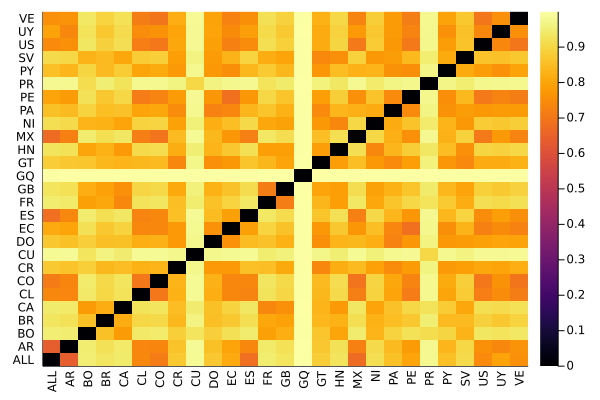

In [10]:
heatmap(cclist, cclist, A, ticks = :all, xrot=90)
savefig("../figs/fig-common-words-semantic-affinity-matrix.pdf")
savefig("../figs/fig-common-words-semantic-affinity-matrix.png")
plot!(fmt=:png)